In [1]:
### 3.1 Load Data and Initial Inspection

import pandas as pd
import numpy as np

# --- CORRECTED FILE PATH ---
# Based on your file system, the file is 'togo-dapaong_qc.csv'
DATA_FILE_PATH = '../togo-dapaong_qc.csv' 

# Load the data, setting the first column as the Timestamp index
df_tg = pd.read_csv(
    DATA_FILE_PATH,
    index_col=0,
    parse_dates=True,
    low_memory=False
)

# Initialize df_cleaned
df_cleaned = df_tg.copy()

print("--- DataFrame Initial Info (Data Types and Non-Null Counts) ---")
df_cleaned.info()

print("\n--- Duplicate Check ---")
total_rows = len(df_cleaned)
duplicate_rows = df_cleaned.duplicated().sum()
print(f"Total rows: {total_rows}")
print(f"Duplicate rows found: {duplicate_rows}")

if duplicate_rows > 0:
    # Drop duplicates, keeping the first occurrence
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Action: Dropped {duplicate_rows} duplicates.")
    
print(f"New row count: {len(df_cleaned)}")

print("\n--- First 5 Rows ---")
print(df_cleaned.head())

--- DataFrame Initial Info (Data Types and Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2021-10-25 00:01:00 to 2022-10-25 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GHI            525600 non-null  float64
 1   DNI            525600 non-null  float64
 2   DHI            525600 non-null  float64
 3   ModA           525600 non-null  float64
 4   ModB           525600 non-null  float64
 5   Tamb           525600 non-null  float64
 6   RH             525600 non-null  float64
 7   WS             525600 non-null  float64
 8   WSgust         525600 non-null  float64
 9   WSstdev        525600 non-null  float64
 10  WD             525600 non-null  float64
 11  WDstdev        525600 non-null  float64
 12  BP             525600 non-null  int64  
 13  Cleaning       525600 non-null  int64  
 14  Precipitation  525600 non-null  float64
 15  TModA          525600

In [3]:
#ssing-Value Report and Descriptive Statistics

# Create a Missing Value Report
missing_report = df_cleaned.isnull().sum().reset_index()
missing_report.columns = ['Column', 'Total Missing']
missing_report['Percent Missing'] = (missing_report['Total Missing'] / len(df_cleaned)) * 100

print("--- 2. Missing Value Report ---")
print(missing_report)

# Identify columns with >5% nulls
high_null_columns = missing_report[missing_report['Percent Missing'] > 5]
print("\nColumns with >5% Nulls:\n", high_null_columns)

# Drop the 'Comments' column as it is entirely empty
if 'Comments' in df_cleaned.columns and df_cleaned['Comments'].isnull().all():
    df_cleaned = df_cleaned.drop(columns=['Comments'])
    print("\nAction: Dropped the entirely null 'Comments' column.")

# Display descriptive statistics for key numeric columns
KEY_COLS = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'TModA', 'TModB']
print("\n--- 3. Descriptive Statistics for Key Metrics ---")
print(df_cleaned[KEY_COLS].describe())

--- 2. Missing Value Report ---
           Column  Total Missing  Percent Missing
0             GHI              0              0.0
1             DNI              0              0.0
2             DHI              0              0.0
3            ModA              0              0.0
4            ModB              0              0.0
5            Tamb              0              0.0
6              RH              0              0.0
7              WS              0              0.0
8          WSgust              0              0.0
9         WSstdev              0              0.0
10             WD              0              0.0
11        WDstdev              0              0.0
12             BP              0              0.0
13       Cleaning              0              0.0
14  Precipitation              0              0.0
15          TModA              0              0.0
16          TModB              0              0.0
17       Comments         522432            100.0

Columns with >5% 

In [4]:
from scipy.stats import zscore

# --- A. Define Outlier Detection Parameters ---
Z_THRESHOLD = 3
OUTLIER_COLS = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# --- B. Outlier Detection and Flagging ---
df_cleaned['Outlier_Flag'] = False
initial_outlier_count = 0

for col in OUTLIER_COLS:
    # Calculate Z-score for the current column
    df_cleaned[f'{col}_ZScore'] = zscore(df_cleaned[col])
    
    # Identify rows where the absolute Z-score is greater than the threshold
    outlier_rows = df_cleaned[f'{col}_ZScore'].abs() > Z_THRESHOLD
    
    # Update the general Outlier_Flag
    df_cleaned['Outlier_Flag'] = df_cleaned['Outlier_Flag'] | outlier_rows
    
    # Count outliers for this column
    col_outlier_count = outlier_rows.sum()
    print(f"Column {col}: {col_outlier_count} outliers found (|Z| > {Z_THRESHOLD})")
    initial_outlier_count += col_outlier_count

total_flagged_rows = df_cleaned['Outlier_Flag'].sum()
print(f"\nTotal unique rows flagged as outliers across all columns: {total_flagged_rows}")
print(f"Percentage of data flagged: {total_flagged_rows / len(df_cleaned) * 100:.4f}%")


# --- C. Cleaning: Handle Outliers and Physical Errors ---

# 1. Impute Z-score outliers using the column median
for col in OUTLIER_COLS:
    median_val = df_cleaned[col].median()
    df_cleaned.loc[df_cleaned['Outlier_Flag'], col] = median_val
    print(f"Imputed Z-score outliers in {col} with median: {median_val:.2f}")

# 2. Correct physical impossibilities (Negative Solar Irradiance)
for col in ['GHI', 'DNI', 'DHI']:
    negative_count = (df_cleaned[col] < 0).sum()
    if negative_count > 0:
        # Set negative values to zero (physical impossibility fix)
        df_cleaned.loc[df_cleaned[col] < 0, col] = 0
        print(f"Action: Set {negative_count} negative values in {col} to 0.")

# --- D. Final Status Check ---
print("\n--- Final Status Check ---")
print(df_cleaned[OUTLIER_COLS].describe())

Column GHI: 295 outliers found (|Z| > 3)
Column DNI: 998 outliers found (|Z| > 3)
Column DHI: 3308 outliers found (|Z| > 3)
Column ModA: 133 outliers found (|Z| > 3)
Column ModB: 199 outliers found (|Z| > 3)
Column WS: 3510 outliers found (|Z| > 3)
Column WSgust: 3915 outliers found (|Z| > 3)

Total unique rows flagged as outliers across all columns: 9080
Percentage of data flagged: 1.7380%
Imputed Z-score outliers in GHI with median: 3.30
Imputed Z-score outliers in DNI with median: 0.00
Imputed Z-score outliers in DHI with median: 3.80
Imputed Z-score outliers in ModA with median: 5.40
Imputed Z-score outliers in ModB with median: 5.30
Imputed Z-score outliers in WS with median: 2.20
Imputed Z-score outliers in WSgust with median: 3.00
Action: Set 252709 negative values in GHI to 0.

--- Final Status Check ---
                 GHI            DNI            DHI           ModA  \
count  522432.000000  522432.000000  522432.000000  522432.000000   
mean      222.747007     146.403400   

Action: Cleaned data exported to ./data/togo_clean.csv

Daily resampled data head:
                   GHI         DNI         DHI       Tamb
Timestamp                                                
2021-10-25  218.555230  112.688145  140.247141  28.416457
2021-10-26  262.727153  242.010556   98.657778  28.815833
2021-10-27  256.462431  221.792222  100.251389  28.194931
2021-10-28  248.994097  220.409167  104.235764  27.953542
2021-10-29  266.438611  274.342014   79.688333  28.337847


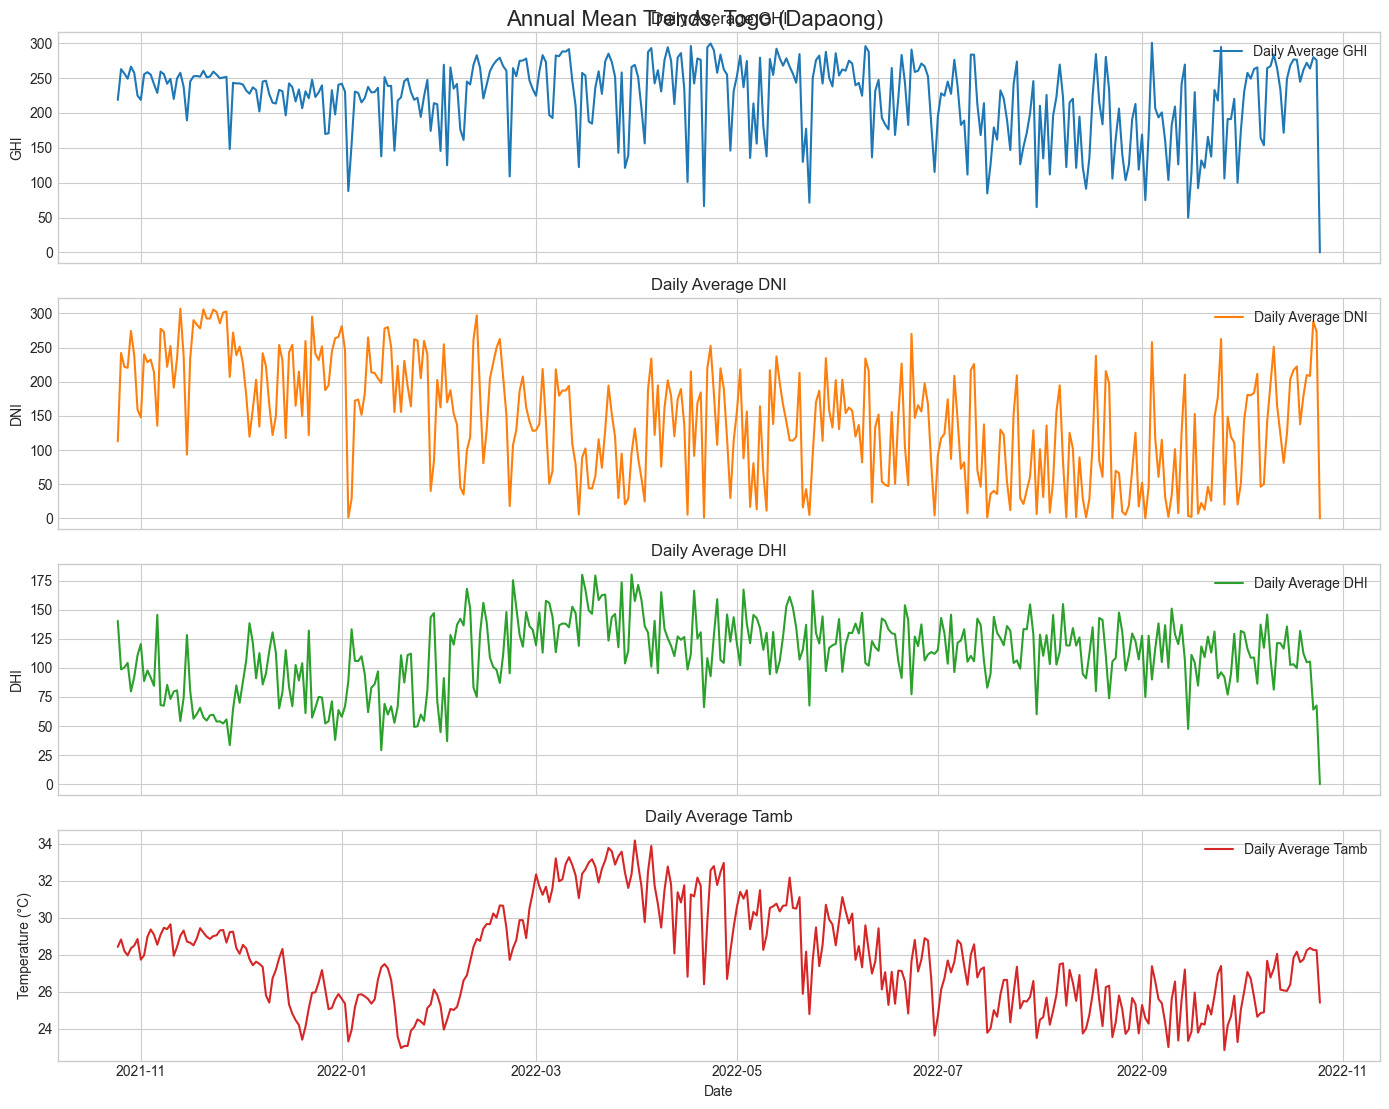

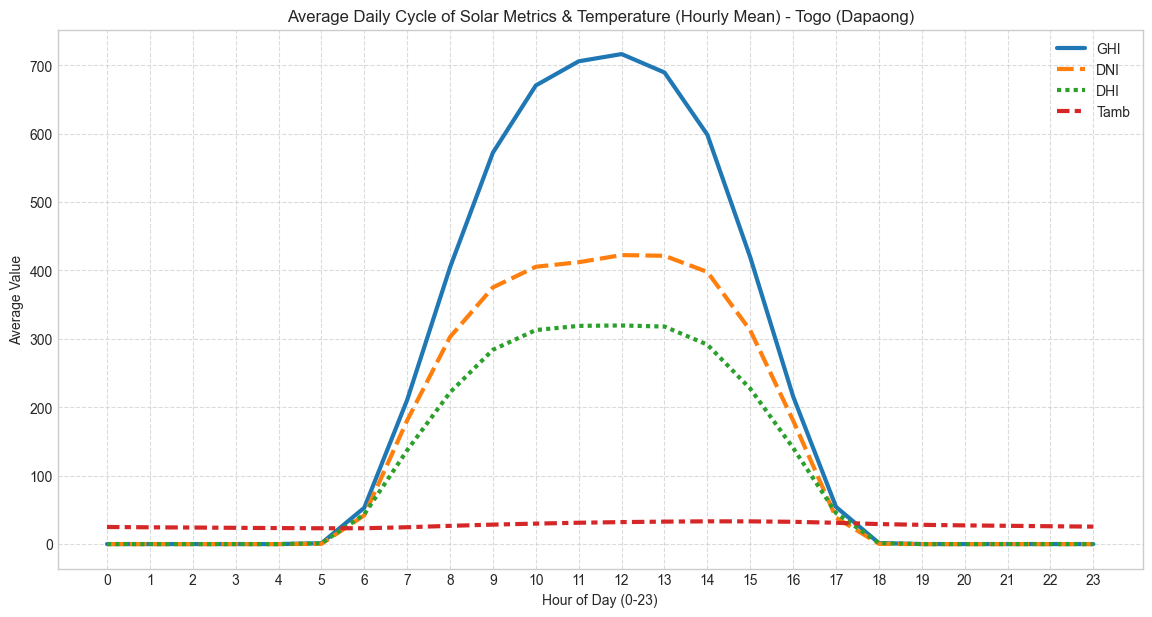

In [6]:
# --- A. Export Cleaned Data ---
CLEAN_FILE_PATH = './data/togo_clean.csv'

# Drop Z-score columns before exporting
df_cleaned = df_cleaned.drop(columns=[col for col in df_cleaned.columns if 'ZScore' in col], errors='ignore')
df_cleaned = df_cleaned.drop(columns=['Comments', 'Outlier_Flag'], errors='ignore')


# Export the cleaned data
df_cleaned.to_csv(CLEAN_FILE_PATH)
print(f"Action: Cleaned data exported to {CLEAN_FILE_PATH}")

# --- B. Time Series Resampling (Daily Mean) ---
# Resample to daily mean for annual trends
df_daily = df_cleaned[['GHI', 'DNI', 'DHI', 'Tamb']].resample('D').mean()
print("\nDaily resampled data head:")
print(df_daily.head())

# --- C. Plot Annual Trends (Line Charts) ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
plt.suptitle('Annual Mean Trends: Togo (Dapaong)', fontsize=16, y=0.92)

# Plot GHI
axes[0].plot(df_daily.index, df_daily['GHI'], label='Daily Average GHI', color='C0')
axes[0].set_title('Daily Average GHI')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('GHI')

# Plot DNI
axes[1].plot(df_daily.index, df_daily['DNI'], label='Daily Average DNI', color='C1')
axes[1].set_title('Daily Average DNI')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('DNI')

# Plot DHI
axes[2].plot(df_daily.index, df_daily['DHI'], label='Daily Average DHI', color='C2')
axes[2].set_title('Daily Average DHI')
axes[2].legend(loc='upper right')
axes[2].set_ylabel('DHI')

# Plot Tamb
axes[3].plot(df_daily.index, df_daily['Tamb'], label='Daily Average Tamb', color='C3')
axes[3].set_title('Daily Average Tamb')
axes[3].legend(loc='upper right')
axes[3].set_ylabel('Temperature (°C)')
axes[3].set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- D. Time Series Resampling (Hourly Mean for Daily Cycle) ---
# Calculate the mean value for each hour of the day across the entire year
df_hourly = df_cleaned[['GHI', 'DNI', 'DHI', 'Tamb']].groupby(df_cleaned.index.hour).mean()
df_hourly.index.name = 'Hour of Day (0-23)'

# Plot Daily Cycle
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_hourly, linewidth=3)
plt.title('Average Daily Cycle of Solar Metrics & Temperature (Hourly Mean) - Togo (Dapaong)')
plt.ylabel('Average Value')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Average Module Performance by Cleaning Status:
                ModA        ModB
Cleaning                        
0         217.032931  210.741617
1         513.961922  512.408185


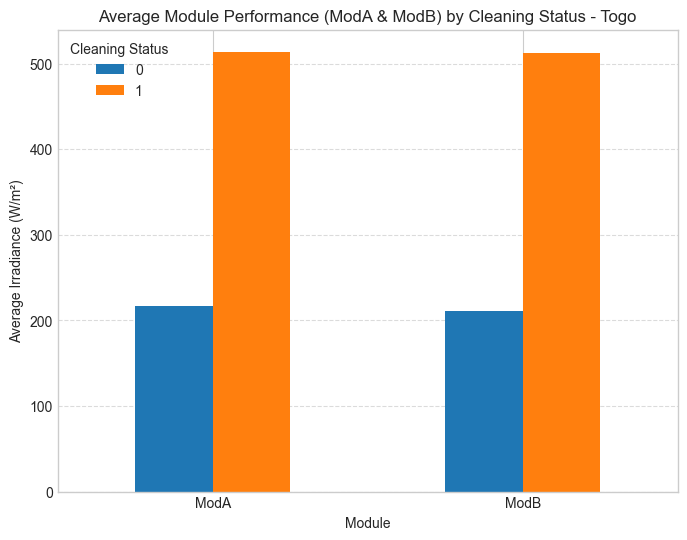

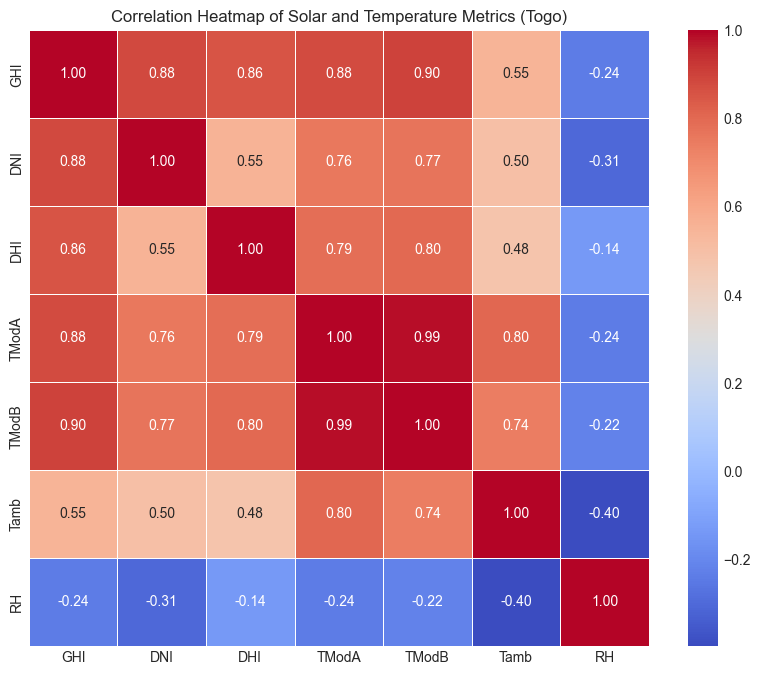

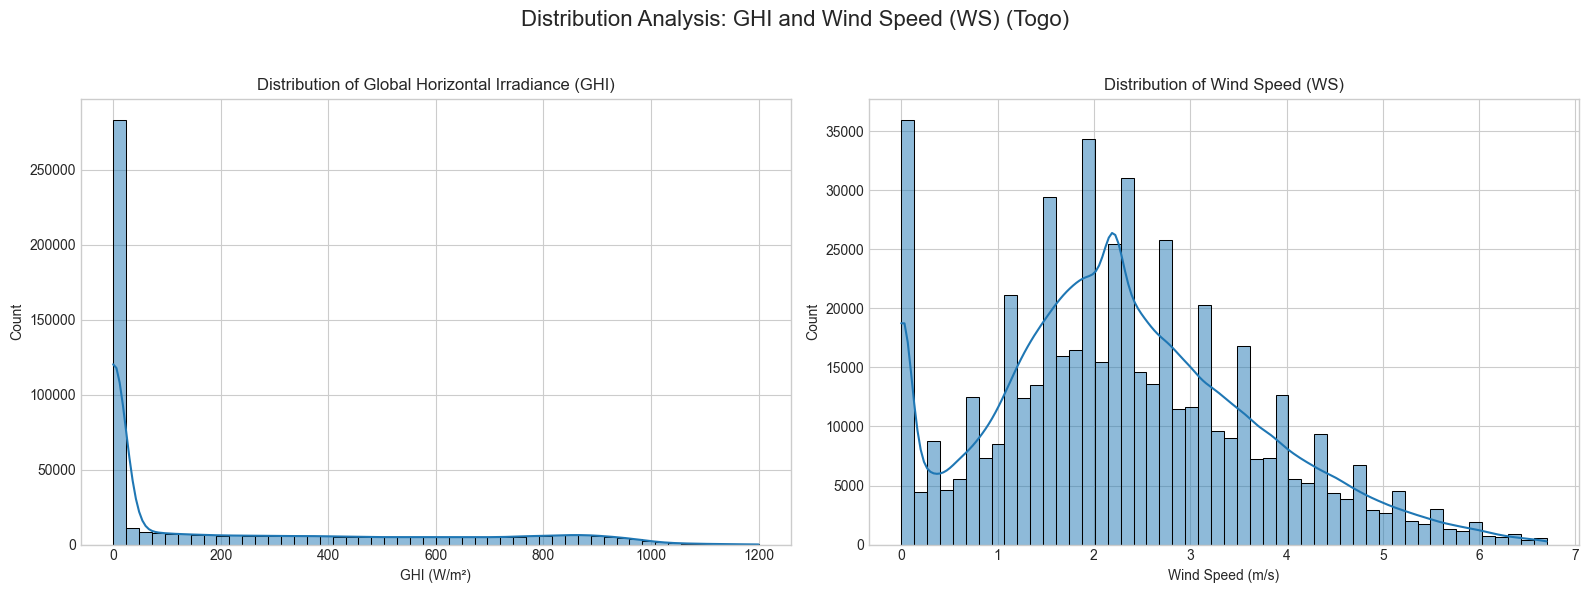

C:\Users\Mer\AppData\Local\Temp\ipykernel_4296\3437132803.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_by_sector = df_cleaned.groupby('WD_Sector')['WS'].mean().reindex(labels)


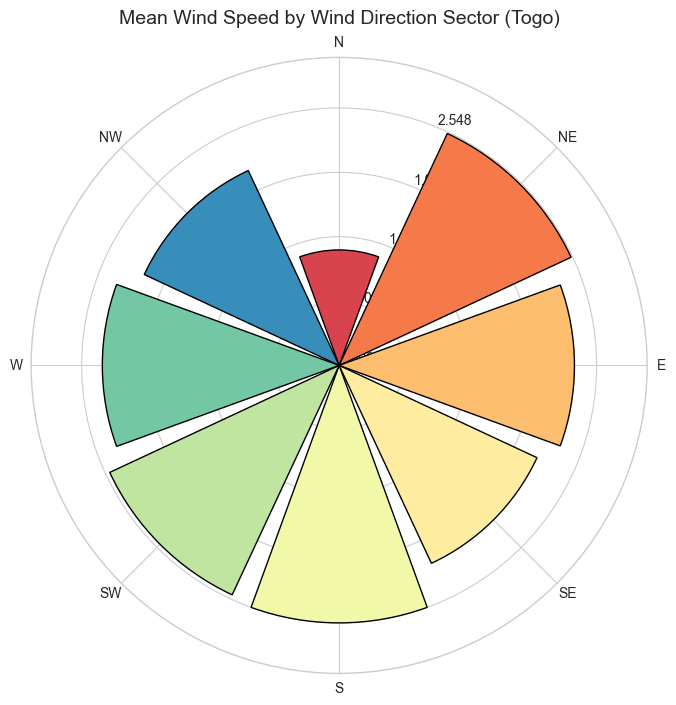

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- A. Cleaning Impact Analysis ---
# Calculate average module irradiance (ModA & ModB) grouped by Cleaning status (0=No Cleaning, 1=Cleaning Occurred)
cleaning_impact = df_cleaned.groupby('Cleaning')[['ModA', 'ModB']].mean()
print("Average Module Performance by Cleaning Status:")
print(cleaning_impact)

# Plotting the impact
fig, ax = plt.subplots(figsize=(8, 6))
cleaning_impact.T.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Average Module Performance (ModA & ModB) by Cleaning Status - Togo')
ax.set_ylabel('Average Irradiance (W/m²)')
ax.set_xlabel('Module')
ax.legend(title='Cleaning Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- B. Correlation Heatmap (Task 3, Step 6) ---
CORR_COLS = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH']
corr_matrix = df_cleaned[CORR_COLS].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='white')
plt.title('Correlation Heatmap of Solar and Temperature Metrics (Togo)')
plt.show()

# --- C. Distribution Analysis (Histograms) (Task 3, Step 6) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Distribution Analysis: GHI and Wind Speed (WS) (Togo)', fontsize=16)

# 1. Distribution of GHI
sns.histplot(df_cleaned['GHI'], kde=True, bins=50, ax=axes[0])
axes[0].set_title('Distribution of Global Horizontal Irradiance (GHI)')
axes[0].set_xlabel('GHI (W/m²)')

# 2. Distribution of Wind Speed (WS)
sns.histplot(df_cleaned['WS'], kde=True, bins=50, ax=axes[1])
axes[1].set_title('Distribution of Wind Speed (WS)')
axes[1].set_xlabel('Wind Speed (m/s)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- D. Wind Analysis (Radial Bar Plot/Wind Rose) (Task 3, Step 6) ---
# Use the corrected bin logic from the Sierra Leone fix
bins = np.array([0, 45, 90, 135, 180, 225, 270, 315, 360]) # 9 edges for 8 sectors
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'] # 8 labels
df_cleaned['WD_Sector'] = pd.cut(df_cleaned['WD'], bins, labels=labels, right=False, ordered=False, include_lowest=True)

# Calculate mean wind speed for each sector
wind_by_sector = df_cleaned.groupby('WD_Sector')['WS'].mean().reindex(labels)

# Plotting the Radial Bar Plot (Wind Rose equivalent)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
angles = np.deg2rad(np.arange(0, 360, 45)) 

bars = ax.bar(angles,
              wind_by_sector.values, 
              width=np.deg2rad(40), 
              bottom=0.0, 
              color=sns.color_palette("Spectral", 8),
              edgecolor='black')

ax.set_theta_zero_location("N") # Set North to the top
ax.set_theta_direction(-1) # Clockwise direction
ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax.set_title('Mean Wind Speed by Wind Direction Sector (Togo)', va='bottom', fontsize=14)

# Set the maximum radial limit (R-axis)
max_wind = wind_by_sector.max()
ax.set_rgrids(np.linspace(0, max_wind, 5))
ax.set_rmax(max_wind + 0.5)

plt.show()

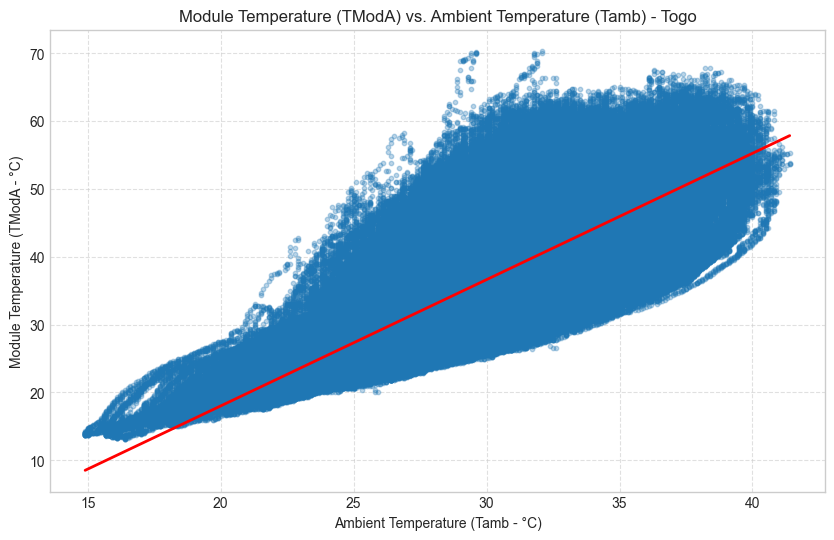

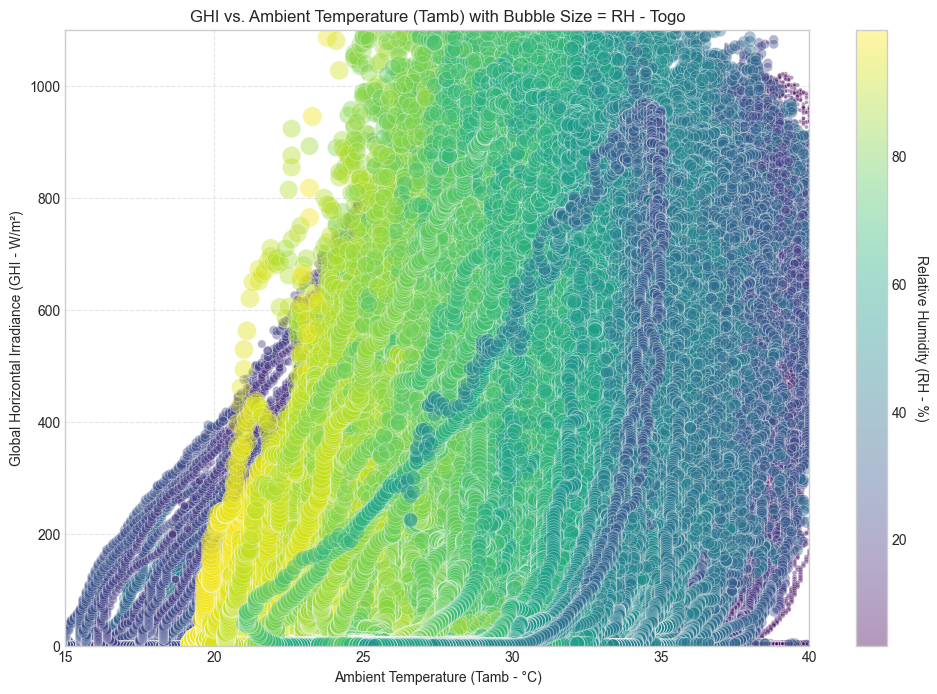

In [8]:
# --- A. Module Temperature vs Ambient Temperature ---
plt.figure(figsize=(10, 6))
sns.regplot(x='Tamb', y='TModA', data=df_cleaned, 
            scatter_kws={'alpha':0.3, 's':10}, 
            line_kws={'color':'red', 'linewidth':2})
plt.title('Module Temperature (TModA) vs. Ambient Temperature (Tamb) - Togo')
plt.xlabel('Ambient Temperature (Tamb - °C)')
plt.ylabel('Module Temperature (TModA - °C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- B. GHI vs. Ambient Temperature with Bubble Size = RH ---
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x=df_cleaned['Tamb'], 
                      y=df_cleaned['GHI'], 
                      s=df_cleaned['RH'] * 2, # Bubble size is RH (scaled up for visibility)
                      c=df_cleaned['RH'], 
                      cmap='viridis', # Colormap for RH
                      alpha=0.4, 
                      edgecolors='w', 
                      linewidths=0.5)

# Add a color bar for Relative Humidity
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity (RH - %)', rotation=270, labelpad=15)

plt.title('GHI vs. Ambient Temperature (Tamb) with Bubble Size = RH - Togo')
plt.xlabel('Ambient Temperature (Tamb - °C)')
plt.ylabel('Global Horizontal Irradiance (GHI - W/m²)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(15, 40) # Set reasonable limits for comparison
plt.ylim(0, 1100)
plt.show()